In [26]:
import os
import random
from collections import Counter
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import torch
import torch.nn.functional as F
from monai.networks.nets import densenet121

import umap
import hdbscan
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from tqdm import tqdm




In [27]:
device = "cpu"  # CPU is safe and avoids GPU kernel crashes
model = densenet121(spatial_dims=2, in_channels=1, out_channels=1000, pretrained=True)
model.eval()
model.to(device)

def collect_image_paths(root_dir):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    return paths

def load_mri_array(path, size=(224,224)):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    img = cv2.resize(img, size)
    img = img.astype(np.float32) / 255.0
    return img[None, None, :, :]  # [1,1,H,W]


def edge_orientation_features(img, n_bins=18):
    gx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=3)
    angles = np.rad2deg(np.arctan2(gy, gx)) % 180.0
    hist, _ = np.histogram(angles, bins=n_bins, range=(0,180), density=True)
    return hist.astype(np.float32)


def extract_features_single(path):
    try:
        img = load_mri_array(path)[0,0]  # shape (H,W)
    except Exception as e:
        print(f"Failed to load {path}: {e}")
        return None

    # RadImageNet embedding
    tensor = torch.from_numpy(img[None, None, :, :]).to(device)
    with torch.no_grad():
        emb = model(tensor).cpu().numpy().reshape(-1)

    # Edge histogram
    edge_hist = edge_orientation_features(img)

    return emb, edge_hist, path


def extract_features(images, max_workers=4):
    """
    Extracts RadImageNet + edge features for all images.
    - images: list of paths
    - max_workers: number of threads for edge histogram computation
    """
    rad_embeddings = []
    edge_feats = []
    good_paths = []

    # Sequential loop with optional ThreadPool for edge computation
    def process_image(path):
        result = extract_features_single(path)
        return result

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(process_image, p) for p in images]
        for f in tqdm(futures, desc="Extracting features"):
            res = f.result()
            if res is not None:
                emb, edge_hist, path = res
                rad_embeddings.append(emb)
                edge_feats.append(edge_hist)
                good_paths.append(path)

    # Stack arrays
    rad_embeddings = np.vstack(rad_embeddings)
    edge_feats = np.vstack(edge_feats)

    # L2-normalize separately then concatenate
    rad_norm = normalize(rad_embeddings, norm="l2")
    edge_norm = normalize(edge_feats, norm="l2")
    full_features = np.hstack([rad_norm, edge_norm])

    return full_features, rad_norm, edge_norm, good_paths


def collect_image_paths(root_dir):
    exts = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
    paths = []
    for root, _, files in os.walk(root_dir):
        for f in files:
            if f.lower().endswith(exts):
                paths.append(os.path.join(root, f))
    return paths

In [28]:
train_path = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Training"
test_path  = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Testing"

all_paths = collect_image_paths(train_path) 


In [29]:
full_features, rad_embeddings, edge_features, paths = extract_features(all_paths, max_workers=4)
print("full_features shape:", full_features.shape)



Extracting features: 100%|██████████| 5521/5521 [08:34<00:00, 10.72it/s]


full_features shape: (5521, 1018)


In [30]:

def random_search_umap_hdbscan(
    X,
    n_iter=20,               # number of random combinations to try
    random_state=42
):
    random.seed(random_state)
    np.random.seed(random_state)

    best_result = {
        "silhouette": -1,
        "calinski": -1,
        "labels": None,
        "umap_params": None,
        "hdbscan_params": None
    }

    for i in range(n_iter):
        
        # --- Random UMAP Params ---
        umap_params = {
            "n_neighbors": random.choice([5, 10, 15, 20, 30]),
            "min_dist": random.uniform(0.0, 0.99),
            "n_components": random.choice([5, 10, 15]),
            "metric": random.choice(["euclidean", "manhattan", "cosine"])
        }

        # Fit UMAP
        umap_model = umap.UMAP(
            n_neighbors=umap_params["n_neighbors"],
            min_dist=umap_params["min_dist"],
            n_components=umap_params["n_components"],
            metric=umap_params["metric"],
            random_state=random_state,
        )

        embedding = umap_model.fit_transform(X)

        # --- Random HDBSCAN Params ---
        hdbscan_params = {
            "min_cluster_size": random.choice([50, 100, 200, 300]),
            "min_samples": random.choice([1, 5, 10]),
            "metric": random.choice(["euclidean", "manhattan", "chebyshev"])
        }

        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=hdbscan_params["min_cluster_size"],
            min_samples=hdbscan_params["min_samples"],
            metric=hdbscan_params["metric"]
        )

        labels = clusterer.fit_predict(embedding)

        # Skip if all noise or only 1 cluster
        if len(set(labels)) <= 1:
            continue

        # Compute metrics
        try:
            sil = silhouette_score(embedding, labels)
        except:
            sil = -1

        try:
            cal = calinski_harabasz_score(embedding, labels)
        except:
            cal = -1

        print(f"Iter {i+1}/{n_iter}")
        print("  Silhouette:", round(sil, 4))
        print("  Calinski:", round(cal, 2))
        print("  UMAP:", umap_params)
        print("  HDBSCAN:", hdbscan_params)
        print("---------------------------")

        # Combine both metrics (you can weight differently)
        score = sil + (cal / 10000)

        # Update best result
        if score > (best_result["silhouette"] + best_result["calinski"] / 10000):
            best_result.update({
                "silhouette": sil,
                "calinski": cal,
                "labels": labels,
                "umap_params": umap_params,
                "hdbscan_params": hdbscan_params
            })

    return best_result


In [31]:
results = random_search_umap_hdbscan(full_features, n_iter=20)

print("Best Silhouette:", results["silhouette"])
print("Best Calinski:", results["calinski"])
print("Best UMAP Params:", results["umap_params"])
print("Best HDBSCAN Params:", results["hdbscan_params"])

best_labels = results["labels"]

/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 1/20
  Silhouette: 0.5398
  Calinski: 1989.93
  UMAP: {'n_neighbors': 5, 'min_dist': 0.024760647670440266, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 2/20
  Silhouette: 0.1983
  Calinski: 920.07
  UMAP: {'n_neighbors': 5, 'min_dist': 0.6699324925486821, 'n_components': 15, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 3/20
  Silhouette: 0.5326
  Calinski: 1723.46
  UMAP: {'n_neighbors': 5, 'min_dist': 0.21645159505556733, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 50, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 4/20
  Silhouette: 0.4116
  Calinski: 4843.1
  UMAP: {'n_neighbors': 30, 'min_dist': 0.4153246227520421, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 5/20
  Silhouette: 0.4635
  Calinski: 6715.03
  UMAP: {'n_neighbors': 20, 'min_dist': 0.33684801135281195, 'n_components': 5, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 6/20
  Silhouette: 0.5522
  Calinski: 14302.16
  UMAP: {'n_neighbors': 20, 'min_dist': 0.09574921306512937, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 7/20
  Silhouette: 0.2613
  Calinski: 2374.02
  UMAP: {'n_neighbors': 20, 'min_dist': 0.5308658105401537, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 8/20
  Silhouette: 0.2217
  Calinski: 2013.01
  UMAP: {'n_neighbors': 15, 'min_dist': 0.5715786238041944, 'n_components': 15, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 50, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 9/20
  Silhouette: 0.134
  Calinski: 1158.61
  UMAP: {'n_neighbors': 15, 'min_dist': 0.9753693054541501, 'n_components': 5, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 5, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 10/20
  Silhouette: 0.5499
  Calinski: 11573.4
  UMAP: {'n_neighbors': 15, 'min_dist': 0.16102755618452397, 'n_components': 10, 'metric': 'euclidean'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 11/20
  Silhouette: 0.2927
  Calinski: 1209.88
  UMAP: {'n_neighbors': 5, 'min_dist': 0.6030396956103183, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 1, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 12/20
  Silhouette: 0.4971
  Calinski: 6531.4
  UMAP: {'n_neighbors': 20, 'min_dist': 0.2672483485164352, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 10, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 13/20
  Silhouette: 0.4545
  Calinski: 1664.94
  UMAP: {'n_neighbors': 5, 'min_dist': 0.22675759124446332, 'n_components': 5, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 5, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 14/20
  Silhouette: 0.1451
  Calinski: 212.31
  UMAP: {'n_neighbors': 10, 'min_dist': 0.9040047629436896, 'n_components': 15, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'chebyshev'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 15/20
  Silhouette: 0.5617
  Calinski: 23761.23
  UMAP: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 16/20
  Silhouette: 0.2253
  Calinski: 1817.11
  UMAP: {'n_neighbors': 10, 'min_dist': 0.7375390922706905, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 10, 'metric': 'manhattan'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 17/20
  Silhouette: 0.4961
  Calinski: 7247.78
  UMAP: {'n_neighbors': 15, 'min_dist': 0.21712755156571048, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 1, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 18/20
  Silhouette: 0.4871
  Calinski: 2960.3
  UMAP: {'n_neighbors': 5, 'min_dist': 0.15131290615477844, 'n_components': 5, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 300, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 19/20
  Silhouette: 0.4443
  Calinski: 5493.42
  UMAP: {'n_neighbors': 20, 'min_dist': 0.3778030936414714, 'n_components': 10, 'metric': 'cosine'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 10, 'metric': 'euclidean'}
---------------------------


/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Iter 20/20
  Silhouette: 0.1123
  Calinski: 415.19
  UMAP: {'n_neighbors': 5, 'min_dist': 0.674893265336309, 'n_components': 15, 'metric': 'manhattan'}
  HDBSCAN: {'min_cluster_size': 200, 'min_samples': 1, 'metric': 'manhattan'}
---------------------------
Best Silhouette: 0.5617013573646545
Best Calinski: 23761.22728126975
Best UMAP Params: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
Best HDBSCAN Params: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}


In [32]:
n_clusters = len(set(best_labels) - {-1})
n_noise = np.sum(best_labels == -1)

print("Clusters found:", n_clusters)
print("Noise points:", n_noise)

Clusters found: 3
Noise points: 0


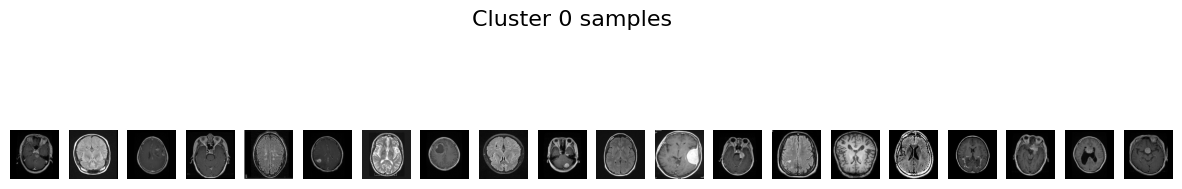

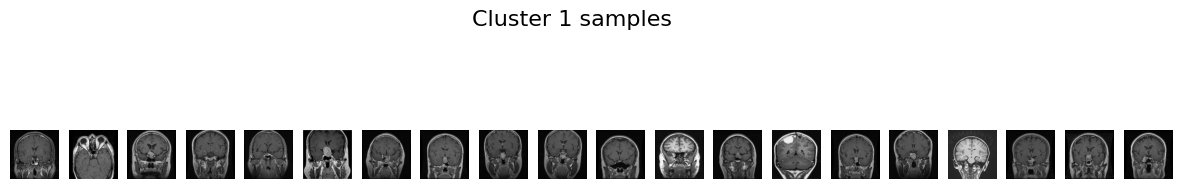

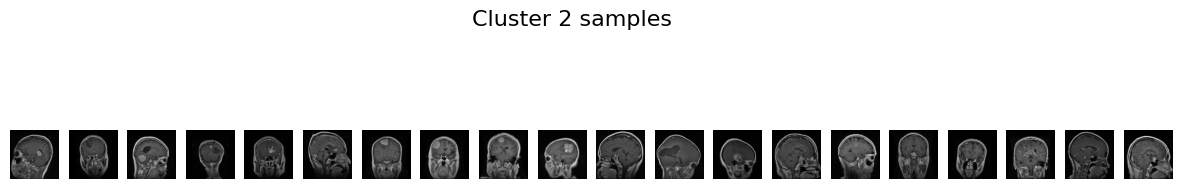

In [33]:

def sample_images_per_cluster(paths, labels, n_samples=5):
    """
    Randomly sample n_samples images per cluster.
    
    Args:
        paths (list): list of image paths
        labels (array): cluster labels from HDBSCAN
        n_samples (int): number of images to sample per cluster
    """
    from collections import defaultdict
    
    # Group paths by cluster
    cluster_dict = defaultdict(list)
    for path, label in zip(paths, labels):
        if label != -1:  # ignore noise points
            cluster_dict[label].append(path)
    
    # Sample images per cluster
    sampled_images = {}
    for cluster, images in cluster_dict.items():
        if len(images) < n_samples:
            sampled_images[cluster] = images
        else:
            sampled_images[cluster] = random.sample(images, n_samples)
    
    return sampled_images, cluster_dict

# ---- Example usage ----
sampled, cluster_dict = sample_images_per_cluster(paths, best_labels, n_samples=20)

# ---- Plot sampled images per cluster ----
for cluster, imgs in sampled.items():
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Cluster {cluster} samples", fontsize=16)
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()


Best Silhouette: 0.7036837935447693
Best Calinski: 48578.71498460905
Best UMAP Params: {'n_neighbors': 20, 'min_dist': 0.3916755820500576, 'n_components': 15, 'metric': 'manhattan'}
Best HDBSCAN Params: {'min_cluster_size': 100, 'min_samples': 5, 'metric': 'euclidean'}

/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/chloelsmith/anaconda3/envs/mri_cluster/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


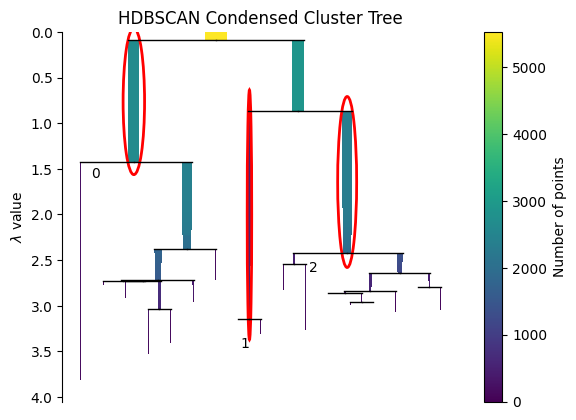

In [34]:

umap_model = umap.UMAP(
            n_neighbors=20,
            min_dist=0.3916755820500576,
            n_components=15,
            metric='manhattan',
            random_state=42,
        )

embedding = umap_model.fit_transform(full_features)

# Assuming your HDBSCAN model is already fit
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=100,
    min_samples=5,
    metric='euclidean',
    prediction_data=True
)

labels = clusterer.fit_predict(embedding)

clusterer.condensed_tree_.plot(
    select_clusters=True,
    label_clusters=True
)
plt.title("HDBSCAN Condensed Cluster Tree")
plt.show()


In [35]:
import torch
import torch.nn.functional as F
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter

def grad_cam(
    model, 
    input_tensor, 
    target_neuron=None, 
    target_layer=None, 
    pool_type='mean',   # 'mean' or 'max'
    use_relu=True, 
    smooth_sigma=0.0,   # sigma for optional Gaussian smoothing
    upsample_method='bilinear'
):
    """
    Compute Grad-CAM for a single image.
    
    Args:
        model: PyTorch model
        input_tensor: Tensor (1,C,H,W)
        target_neuron: int or None, which neuron in the output to visualize
        target_layer: nn.Module or None, which conv layer to use (default last Conv2d)
        pool_type: 'mean' or 'max' for gradient pooling
        use_relu: bool, whether to apply ReLU to CAM
        smooth_sigma: float, sigma for Gaussian smoothing
        upsample_method: 'bilinear' or 'nearest'
    
    Returns:
        heatmap: numpy array (H,W) in [0,1]
    """
    activations = None
    gradients = None

    def forward_hook(module, inp, out):
        nonlocal activations
        activations = out

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    # If target layer not specified, use last Conv2d
    if target_layer is None:
        for name, m in reversed(list(model.named_modules())):
            if isinstance(m, torch.nn.Conv2d):
                target_layer = m
                break
        if target_layer is None:
            raise ValueError("No Conv2d layer found")

    h1 = target_layer.register_forward_hook(forward_hook)
    h2 = target_layer.register_backward_hook(backward_hook)

    model.eval()
    model.zero_grad()

    output = model(input_tensor)
    if target_neuron is None:
        target_neuron = output.argmax().item()
    target = output[0, target_neuron]
    target.backward()

    # Gradient pooling
    if pool_type == 'mean':
        weights = gradients.mean(dim=(2,3), keepdim=True)
    elif pool_type == 'max':
        weights = gradients.max(dim=(2,3), keepdim=True)[0]
    else:
        raise ValueError("pool_type must be 'mean' or 'max'")

    cam = (weights * activations).sum(dim=1, keepdim=True)
    if use_relu:
        cam = F.relu(cam)
    cam = cam.squeeze().cpu().detach().numpy()

    # Optional Gaussian smoothing
    if smooth_sigma > 0:
        cam = gaussian_filter(cam, sigma=smooth_sigma)

    # Resize to input size
    H, W = input_tensor.shape[2], input_tensor.shape[3]
    if upsample_method == 'bilinear':
        cam = cv2.resize(cam, (W,H), interpolation=cv2.INTER_LINEAR)
    elif upsample_method == 'nearest':
        cam = cv2.resize(cam, (W,H), interpolation=cv2.INTER_NEAREST)
    else:
        raise ValueError("upsample_method must be 'bilinear' or 'nearest'")

    # Normalize
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    # Remove hooks
    h1.remove()
    h2.remove()

    return cam


In [36]:
def overlay_heatmap(img, heatmap, alpha=0.5, colormap=cv2.COLORMAP_JET):
    """
    Overlay Grad-CAM heatmap on grayscale image
    """
    heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap), colormap)
    img_color = cv2.cvtColor(np.uint8(img*255), cv2.COLOR_GRAY2BGR)
    overlay = cv2.addWeighted(img_color, 1-alpha, heatmap_color, alpha, 0)
    return overlay


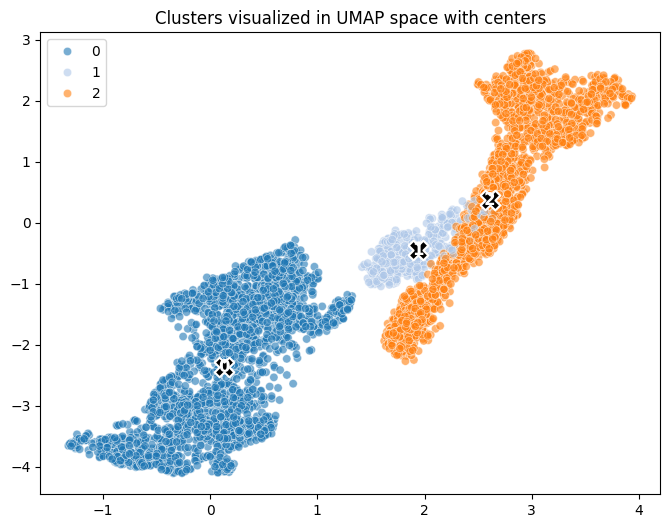

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(8,6))

# Scatter plot of points
sns.scatterplot(
    x=embedding[:,0], 
    y=embedding[:,1], 
    hue=labels, 
    palette="tab20", 
    legend="full",
    alpha=0.6  # semi-transparent
)

# Compute and plot cluster centers
for lbl in np.unique(labels):
    x_mean = embedding[labels==lbl, 0].mean()
    y_mean = embedding[labels==lbl, 1].mean()
    plt.scatter(
        x_mean, y_mean, 
        s=200,           # bigger marker for center
        color='black',   # black for contrast
        marker='X',      # cross marker
        edgecolor='white',
        linewidth=1.5,
        zorder=5         # on top of scatter points
    )
    plt.text(x_mean, y_mean, str(lbl), fontsize=12, fontweight='bold',
             color='white', ha='center', va='center', zorder=6)

plt.title("Clusters visualized in UMAP space with centers")
plt.show()





In [39]:
test_path  = "/Users/chloelsmith/Desktop/archive-2/Grayscale_Testing"
test_paths = collect_image_paths(test_path) 

In [40]:
full_features_test, rad_embeddings_test, edge_features_test, paths_test = extract_features(test_paths, max_workers=4)
print("full_features shape:", full_features_test.shape)

Extracting features: 100%|██████████| 1205/1205 [01:47<00:00, 11.23it/s]


full_features shape: (1205, 1018)


In [41]:
# Transform test set using the trained UMAP
test_embedding = umap_model.transform(full_features_test)

# Predict test clusters with approximate_predict
from hdbscan import approximate_predict
test_labels, test_probs = approximate_predict(clusterer, test_embedding)


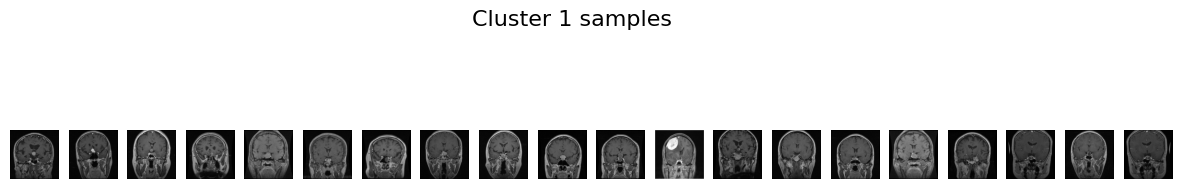

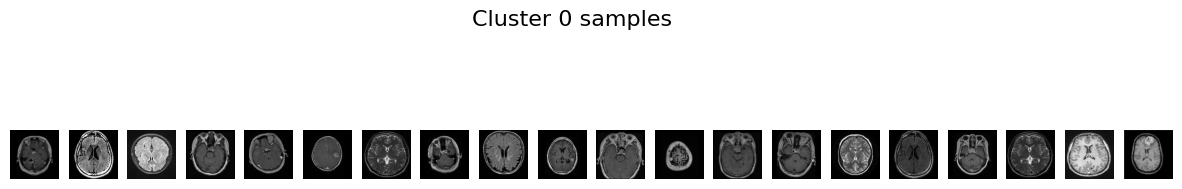

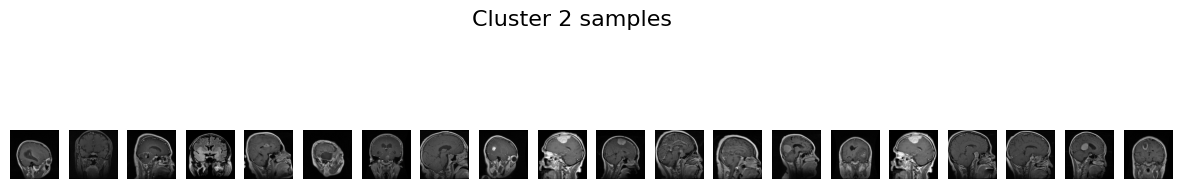

In [42]:
sampled, test_cluster_dict = sample_images_per_cluster(test_paths, test_labels, n_samples=20)

# ---- Plot sampled images per cluster ----
for cluster, imgs in sampled.items():
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Cluster {cluster} samples", fontsize=16)
    for i, img_path in enumerate(imgs):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, len(imgs), i+1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()

Overall we observe a good test performance! 

In [43]:
sil_score = silhouette_score(test_embedding, test_labels)
print("Silhouette score:", sil_score)

# Calinski-Harabasz index
ch_score = calinski_harabasz_score(test_embedding, test_labels)
print("Calinski-Harabasz index:", ch_score)

Silhouette score: 0.43809059262275696
Calinski-Harabasz index: 3387.338946114717


(this is the train performance as a reminder)

In [44]:
sil_score = silhouette_score(embedding, labels)
print("Silhouette score:", sil_score)

# Calinski-Harabasz index
ch_score = calinski_harabasz_score(embedding, labels)
print("Calinski-Harabasz index:", ch_score)

Silhouette score: 0.5617013573646545
Calinski-Harabasz index: 23761.22728126975


In [51]:
data = []
for cluster_label, paths in cluster_dict.items():
    for path in paths:
        # Extract folder name just before the filename
        tumor_type = os.path.basename(os.path.dirname(path))
        data.append((cluster_label, tumor_type))

# Put into a DataFrame
df = pd.DataFrame(data, columns=['cluster', 'tumor_type'])
cluster_counts = df.groupby(['cluster', 'tumor_type']).size().unstack(fill_value=0)
print(cluster_counts)

tumor_type  glioma  meningioma  notumor  pituitary
cluster                                           
0              481         426     1302        426
1                1          51       18        484
2              839         856      102        535


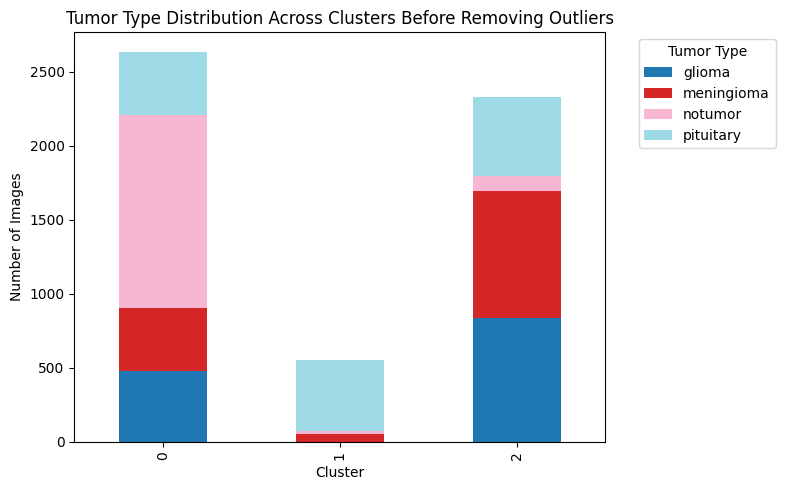

In [52]:
# Before Removing Outliers
cluster_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,5))
plt.title("Tumor Type Distribution Across Clusters Before Removing Outliers")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [53]:
train_outliers_df = pd.read_csv("train_outlier_paths.csv")
test_outliers_df  = pd.read_csv("test_outlier_paths.csv")

train_outliers = set(train_outliers_df['path'].tolist())
test_outliers  = set(test_outliers_df['path'].tolist())

tumor_type  glioma  meningioma  notumor  pituitary
cluster                                           
0              481         415     1186        426
1                1          50       16        484
2              839         850      100        535


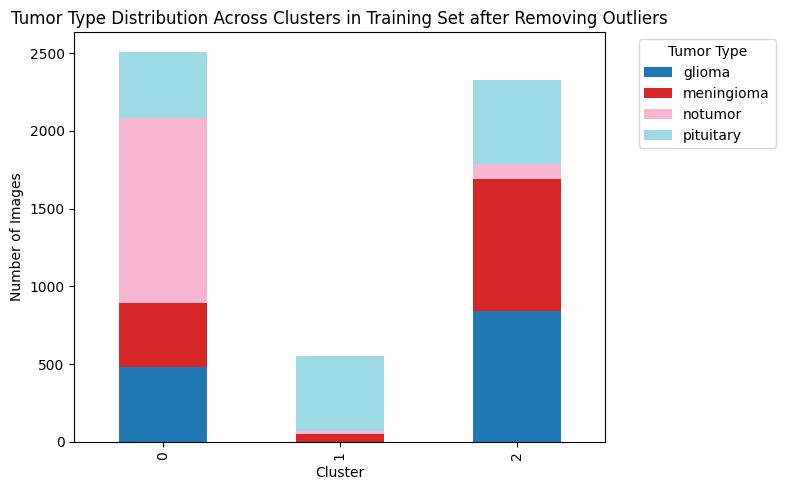

In [54]:
# Combine train and test outliers into a single set for easy lookup
all_outliers = train_outliers.union(test_outliers)

# Filter cluster_dict
filtered_cluster_dict = {}
for cluster_label, paths in cluster_dict.items():
    # Keep only paths that are not in outliers
    filtered_paths = [p for p in paths if p not in all_outliers]
    if filtered_paths:  # only keep clusters that still have items
        filtered_cluster_dict[cluster_label] = filtered_paths

# Rebuild DataFrame
data = []
for cluster_label, paths in filtered_cluster_dict.items():
    for path in paths:
        tumor_type = os.path.basename(os.path.dirname(path))
        data.append((cluster_label, tumor_type))

df = pd.DataFrame(data, columns=['cluster', 'tumor_type'])

# Get cluster counts by tumor_type
cluster_counts = df.groupby(['cluster', 'tumor_type']).size().unstack(fill_value=0)
print(cluster_counts)

# After Removing Outliers
cluster_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,5))
plt.title("Tumor Type Distribution Across Clusters in Training Set after Removing Outliers")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

tumor_type  glioma  meningioma  notumor  pituitary
cluster                                           
0              481         415     1186        426
1                1          50       16        484
2              839         850      100        535


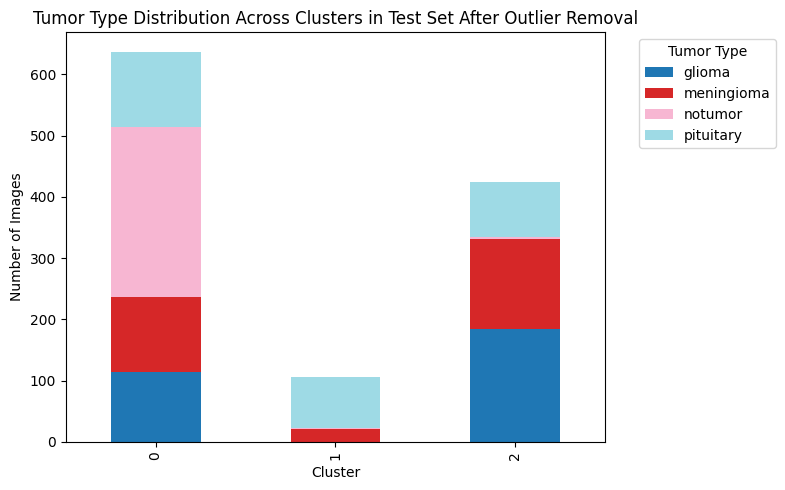

In [91]:
# Filter cluster_dict
filtered_cluster_test_dict = {}
for cluster_label, paths in test_cluster_dict.items():
    # Keep only paths that are not in outliers
    filtered_paths = [p for p in paths if p not in all_outliers]
    if filtered_paths:  # only keep clusters that still have items
        filtered_cluster_test_dict[cluster_label] = filtered_paths

# Rebuild DataFrame
data = []
for cluster_label, paths in filtered_cluster_dict.items():
    for path in paths:
        tumor_type = os.path.basename(os.path.dirname(path))
        data.append((cluster_label, tumor_type))

df = pd.DataFrame(data, columns=['cluster', 'tumor_type'])

# Get cluster counts by tumor_type
test_cluster_counts = df.groupby(['cluster', 'tumor_type']).size().unstack(fill_value=0)
print(cluster_counts)

# After Removing Outliers
test_cluster_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(8,5))
plt.title("Tumor Type Distribution Across Clusters in Test Set After Outlier Removal")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.legend(title="Tumor Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



===== Training model for axial cluster =====
Epoch 1/5 | Loss: 1.3558 | Train Acc: 0.3485 | Train MCC: 0.0294
Epoch 2/5 | Loss: 1.2413 | Train Acc: 0.4929 | Train MCC: 0.2129
Epoch 3/5 | Loss: 1.1524 | Train Acc: 0.5542 | Train MCC: 0.3337
Epoch 4/5 | Loss: 1.0699 | Train Acc: 0.6107 | Train MCC: 0.4349
Epoch 5/5 | Loss: 1.0114 | Train Acc: 0.6641 | Train MCC: 0.5186

--- Test Accuracy: 0.7724 | Test MCC: 0.6835 ---


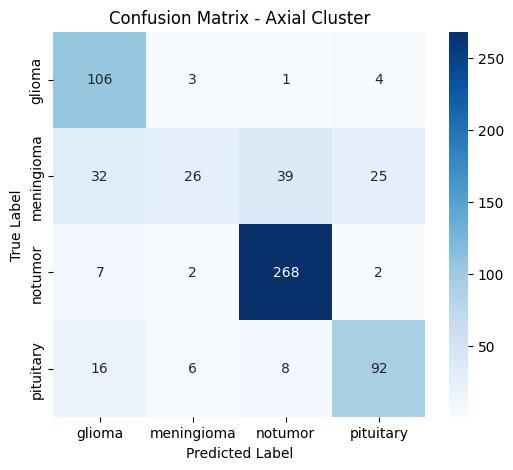



===== Training model for coronal cluster =====
Epoch 1/5 | Loss: 0.6767 | Train Acc: 0.5673 | Train MCC: 0.1109
Epoch 2/5 | Loss: 0.6200 | Train Acc: 0.7404 | Train MCC: 0.1498
Epoch 3/5 | Loss: 0.5617 | Train Acc: 0.8077 | Train MCC: 0.2473
Epoch 4/5 | Loss: 0.5707 | Train Acc: 0.7596 | Train MCC: -0.0217
Epoch 5/5 | Loss: 0.5617 | Train Acc: 0.7788 | Train MCC: 0.0240

--- Test Accuracy: 0.7885 | Test MCC: -0.0496 ---


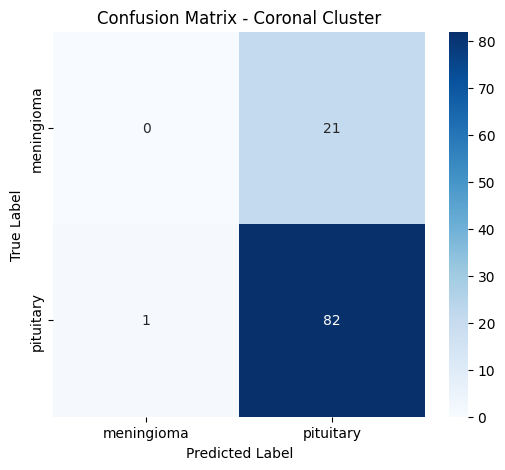



===== Training model for sagittal cluster =====
Epoch 1/5 | Loss: 1.1074 | Train Acc: 0.3373 | Train MCC: -0.0352
Epoch 2/5 | Loss: 1.0638 | Train Acc: 0.4086 | Train MCC: 0.0295
Epoch 3/5 | Loss: 1.0390 | Train Acc: 0.4632 | Train MCC: 0.1134
Epoch 4/5 | Loss: 1.0274 | Train Acc: 0.4751 | Train MCC: 0.1337
Epoch 5/5 | Loss: 0.9929 | Train Acc: 0.5297 | Train MCC: 0.2381

--- Test Accuracy: 0.5819 | Test MCC: 0.3383 ---


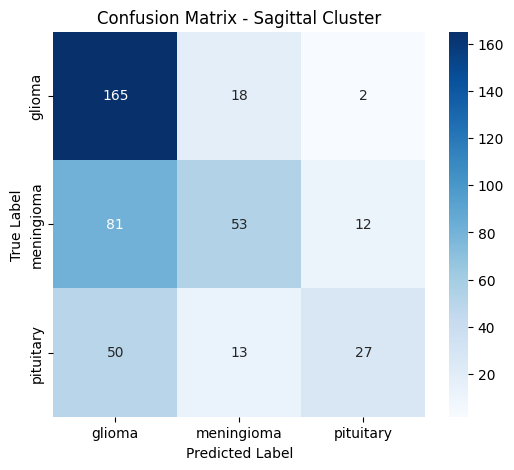

In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, matthews_corrcoef
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class MRIDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.labels[idx]
        return img, label

img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

clusters = ["axial", "coronal", "sagittal"]

# Training clusters
train_clusters = {
    "axial": filtered_cluster_dict[0],
    "coronal": filtered_cluster_dict[1],
    "sagittal": filtered_cluster_dict[2]
}

# Testing clusters
test_clusters = {
    "axial": filtered_cluster_test_dict[0],
    "coronal": filtered_cluster_test_dict[1],
    "sagittal": filtered_cluster_test_dict[2]
}


batch_size = 16
epochs = 5
lr = 1e-4


for cluster_name in clusters:
    print(f"\n\n===== Training model for {cluster_name} cluster =====")
    
    # Paths and labels
    train_paths = train_clusters[cluster_name]
    test_paths = test_clusters[cluster_name]
    
    train_labels = [os.path.basename(os.path.dirname(p)) for p in train_paths]
    test_labels  = [os.path.basename(os.path.dirname(p)) for p in test_paths]

    # --- CORONAL: filter for meningioma vs pituitary only ---
    if cluster_name == "coronal":
        allowed_classes = {"meningioma", "pituitary"}
        filtered_train = [(p, l) for p, l in zip(train_paths, train_labels) if l in allowed_classes]
        filtered_test  = [(p, l) for p, l in zip(test_paths, test_labels) if l in allowed_classes]
        if not filtered_train or not filtered_test:
            print(f"No data left after filtering for {cluster_name}")
            continue
        train_paths, train_labels = zip(*filtered_train)
        test_paths, test_labels = zip(*filtered_test)

    # --- SAGITTAL: drop "no tumor", keep 3 classes ---
    if cluster_name == "sagittal":
        filtered_train = [(p, l) for p, l in zip(train_paths, train_labels) if l != "notumor"]
        filtered_test  = [(p, l) for p, l in zip(test_paths, test_labels) if l != "notumor"]
        if not filtered_train or not filtered_test:
            print(f"No data left after filtering for {cluster_name}")
            continue
        train_paths, train_labels = zip(*filtered_train)
        test_paths, test_labels = zip(*filtered_test)

    # Encode labels
    le = LabelEncoder()
    y_train = torch.tensor(le.fit_transform(train_labels))
    y_test  = torch.tensor(le.transform(test_labels))

    # Datasets and loaders
    train_dataset = MRIDataset(train_paths, y_train, train_transform)
    test_dataset  = MRIDataset(test_paths, y_test, test_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, num_workers=0, pin_memory=True)

    # Model
    model = models.efficientnet_v2_s(weights="IMAGENET1K_V1")
    for param in model.features.parameters():
        param.requires_grad = False
    num_classes = len(le.classes_)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    model = model.to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier[1].parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0
        all_preds = []
        all_labels = []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader.dataset)
        train_acc = (np.array(all_preds) == np.array(all_labels)).mean()
        train_mcc = matthews_corrcoef(all_labels, all_preds)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.4f} | Train Acc: {train_acc:.4f} | Train MCC: {train_mcc:.4f}")

    # Evaluation on test set
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = accuracy_score(all_labels, all_preds)
    test_mcc = matthews_corrcoef(all_labels, all_preds)
    print(f"\n--- Test Accuracy: {test_acc:.4f} | Test MCC: {test_mcc:.4f} ---")

    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.title(f"Confusion Matrix - {cluster_name.capitalize()} Cluster")
    plt.show()
